In [1]:
from entsoe import EntsoePandasClient
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Scrape data from ENTSOE API
* https://github.com/EnergieID/entsoe-py
* Day ahead prices
* Load
* Load Forecast
* Load and forecast
* Generation Forecast
* Wind and Solar Forecast
* Scheduled Exchanges
* Net Transfer Capacity

In [2]:
# Define the EntsoePandasClient object with the API key
client = EntsoePandasClient(api_key='a6160036-4d49-4c39-960f-99c3c690b6da', retry_count=60, retry_delay=10)

# Define the time period and the country codes
# start = pd.Timestamp('20220601', tz='Europe/Copenhagen')
# end = pd.Timestamp('20220630', tz='Europe/Copenhagen')
start_date = pd.Timestamp('20230101 00:00:00', tz='Europe/Brussels').tz_convert('UTC')
end_date = pd.Timestamp('20231231 23:00:00', tz='Europe/Brussels').tz_convert('UTC')
country_codes = ['DK_1', 'DK_2', 'SE_1', 'SE_2', 'SE_3', 'SE_4', 'NO_1', 'NO_2', 'NO_3', 'NO_4', 'NO_5', 'FI']

In [3]:
# Create empty dataframes for storing the data
day_ahead_prices = pd.DataFrame()
scheduled_exchanges = pd.DataFrame()
net_transfer_capacity = pd.DataFrame()
load = pd.DataFrame()
load_forecast = pd.DataFrame()
load_and_forecast = pd.DataFrame()
generation_forecast = pd.DataFrame()
wind_and_solar_forecast = pd.DataFrame()

In [4]:
# Loop over the country codes and query the data
for country_code in country_codes:
    # day ahead prices
    day_ahead = pd.DataFrame(client.query_day_ahead_prices(country_code, start=start_date, end=end_date))
    day_ahead['country_code'] = country_code
    day_ahead_prices = pd.concat([day_ahead_prices, day_ahead])
    # load 
    ld = pd.DataFrame(client.query_load(country_code, start=start_date, end=end_date))
    ld['country_code'] = country_code
    load = pd.concat([load, ld])
    # load forecast
    ld_fc = pd.DataFrame(client.query_load_forecast(country_code, start=start_date, end=end_date))
    ld_fc['country_code'] = country_code
    load_forecast = pd.concat([load_forecast, ld_fc])
    # load and forecast
    ld_fc = pd.DataFrame(client.query_load_and_forecast(country_code, start=start_date, end=end_date))
    ld_fc['country_code'] = country_code
    load_and_forecast = pd.concat([load_and_forecast, ld_fc])
    # generation forecast
    gen_fc = pd.DataFrame(client.query_generation_forecast(country_code, start=start_date, end=end_date))
    gen_fc['country_code'] = country_code
    generation_forecast = pd.concat([generation_forecast, gen_fc])
    # wind and solar forecast
    ws_fc = pd.DataFrame(client.query_wind_and_solar_forecast(country_code, start=start_date, end=end_date, psr_type=None))
    ws_fc['country_code'] = country_code
    wind_and_solar_forecast = pd.concat([wind_and_solar_forecast, ws_fc])

Connection Error, retrying in 10 seconds


In [5]:
data_frame_lists = ['day_ahead_prices', 'load', 'load_forecast', 'load_and_forecast', 'generation_forecast', 'wind_and_solar_forecast']
# save dataframes to csv
for data_frame_list in data_frame_lists:
    data = eval(data_frame_list)
    # adjust hour for finnish data as it is in UTC+2
    data_finnish = data[data['country_code'] == 'FI']
    data = data[data['country_code'] != 'FI']
    # subtract 1 hour from the index
    data_finnish.index = data_finnish.index - pd.DateOffset(hours=1)
    # Concat to the original dataframe
    data = pd.concat([data, data_finnish])
    # change the index to be a column
    # data['Timestamp'] = data.index
    # data.index = range(len(data))
    # data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data.to_csv(f'data/{data_frame_list}.csv')

In [6]:
da = pd.read_csv('data/day_ahead_prices.csv')
# rename Unnamed: 0 to Timestamp
da.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
# convert Timestamp to datetime
da_finnish = da[da['country_code'] == 'FI']
da = da[da['country_code'] != 'FI']
da['Timestamp'] = pd.to_datetime(da['Timestamp'])
da['Timestamp'] = da['Timestamp'].dt.tz_localize(None)
da_finnish['Timestamp'] = pd.to_datetime(da_finnish['Timestamp'])
da_finnish['Timestamp'] = da_finnish['Timestamp'].dt.tz_localize(None)
da = pd.concat([da, da_finnish])
da[da['country_code'] == 'FI'].head()


/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_44646/1458004251.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  da['Timestamp'] = pd.to_datetime(da['Timestamp'])


AttributeError: Can only use .dt accessor with datetimelike values

#### Download of cross border data

In [15]:
# Function to query cross-border flows
def queryWeekAheadCapacities(mapping_table, start_date, end_date):

    """
    Query cross-border flows from the ENTSO-E API based on a mapping table.

    Parameters:
    - mapping_table (dict): A mapping table with key-value pairs representing the flow connections.
    - start_date (str): Start date for the query.
    - end_date (str): End date for the query.

    Returns:
    pd.DataFrame: DataFrame containing cross-border flow data with columns ['MTU', 'From', 'To', 'Flow_MW'].

    """

    df_list = []
    for key, values in tqdm(mapping_table.items(), desc='Processing NTCs'):
        for value in tqdm(values, desc=f'Processing NTC from {key}'):
            try:
                data_temp = client.query_net_transfer_capacity_weekahead(key, value, start=start_date, end=end_date)
                data_temp = data_temp.reset_index()
                data_temp['From'] = key
                data_temp['To'] = value
                df_list.append(data_temp)
            except:
                tqdm.write(f'No data for {key} -> {value}')

    print('Done')
    df_queried = pd.concat(df_list, ignore_index=True)
    df_queried = df_queried.rename(columns={0:'WeekAhead_NTC', 'index':'MTU'})

    return df_queried


In [16]:
# Function to convert daily granularity to hourly granularity for cross-border flows
def fromDailyToHourlyGranularity(NTCs, start_date, end_date):

    # Assuming 'index' is the index of your DataFrame
    # Convert 'index' to datetime if it's not already
    NTCs['MTU'] = pd.to_datetime(NTCs['MTU'], utc=True)

    # Set 'index' as the index of your DataFrame
    NTCs.set_index('MTU', inplace=True)

    # Create a secondary index by combining 'From' and 'To'
    NTCs['secondary_index'] = NTCs['From'] + '_' + NTCs['To']

    NTCs_hourly = pd.DataFrame()
    for secondary in NTCs['secondary_index'].unique():
        selection = NTCs.loc[NTCs['secondary_index'] == secondary]

        new_index = pd.date_range(start=start_date, end=end_date, freq='h')
        selection = selection.reindex(new_index)

        # Reset the index to get 'dateTimeUtc' back as a column
        #selection.reset_index(inplace=True)

        # Forward fill to propagate values for new timestamps
        selection = selection.ffill()

        # concat the result to new_table
        NTCs_hourly = pd.concat([NTCs_hourly, selection])

    # drop the secondary index
    NTCs_hourly.drop('secondary_index', axis=1, inplace=True)

    # rename From and To to biddingZoneFrom and biddingZoneTo
    NTCs_hourly.rename(columns={'From':'biddingZoneFrom', 'To':'biddingZoneTo'}, inplace=True)
    NTCs_hourly.index.rename('MTU', inplace=True)

    return NTCs_hourly


In [17]:
# Function to query scheduled exchanges
def query_scheduled_exchanges_ENTSOE(mapping_table, start_date, end_date):

    """
    Query cross-border flows from the ENTSO-E API based on a mapping table.

    Parameters:
    - mapping_table (dict): A mapping table with key-value pairs representing the flow connections.
    - start_date (str): Start date for the query.
    - end_date (str): End date for the query.

    Returns:
    pd.DataFrame: DataFrame containing cross-border flow data with columns ['MTU', 'From', 'To', 'Flow_MW'].

    """

    df_list = []
    for key, values in tqdm(mapping_table.items(), desc='Processing scheduled exchanges'):
        for value in tqdm(values, desc=f'Processing scheduled exchanges from {key}'):
            try:
                data_temp = client.query_scheduled_exchanges(key, value, start=start_date, end=end_date, dayahead=True)
                data_temp = data_temp.reset_index()
                data_temp['From'] = key
                data_temp['To'] = value
                df_list.append(data_temp)
            except:
                tqdm.write(f'No data for {key} -> {value}')

    print('Done')
    df_queried = pd.concat(df_list, ignore_index=True)
    df_queried = df_queried.rename(columns={0:'Sch_Exchange', 'index':'MTU'})

    return df_queried

In [18]:
# Function to achieve hourly granularity of scheduled exchanges
def achieve_hourly_granularity(df):

    """
    Process a DataFrame to achieve hourly granularity of flow data.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing flow data with columns 'MTU', 'From', 'To', and 'Flow_MW'.
                         Here, some MTU may be of 15 minutes granularity, and some may be of 1 hour granularity.

    Returns:
    pd.DataFrame: Processed DataFrame with hourly granularity, where the 'Flow_MW' values are averaged
                  for each hour between 'From' and 'To'.

    Notes:
    - The 'MTU' column is converted to UTC datetime.
    - New columns 'Hour' and 'Date' are created to store the hour and date information, respectively.
    - The DataFrame is then grouped by 'Date', 'Hour', 'From', and 'To' to calculate the average 'Flow_MW'.
    - The 'Date' column is adjusted to represent the midpoint of each hour by adding 30 minutes.
    - The 'Hour' column is dropped from the final result.

    """

    # Convert 'MTU' column to UTC datetime
    df['MTU'] = pd.to_datetime(df['MTU'], utc=True)

    # Create a new column 'Hour' to store the hour information
    df['Hour'] = df['MTU'].dt.hour

    # Create a new column 'Date' to store the date information
    df['Date'] = df['MTU'].dt.date

    # Group by 'Date', 'Hour', 'From', and 'To' and calculate the average flow value
    df = df.groupby(['Date', 'Hour', 'From', 'To'])['Sch_Exchange'].mean().reset_index()

    # Convert 'index' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    df['Date'] = df['Date'] + pd.to_timedelta(df['Hour'].astype(str) + ':00:00')
    df.drop(columns=['Hour'], inplace=True)

    df.rename(columns={'Date': 'MTU'}, inplace=True)

    return df

In [19]:
# Function to define cross border connections and run the queries
def main_border_queries(start_date, end_date):

    #####################
    ### MAPPING TABLE ###
    #####################

    NEIGHBOURS_Real_System = {
        'NL': ['NO_2', 'DK_1'],
        'DE_AT_LU': ['DK_1', 'DK_2', 'SE_4'],
        'GB': ['NO_2','DK_1'],
        'NO_2': ['DE_LU', 'DK_1', 'NL', 'NO_1', 'NO_5', 'GB'],
        'PL': ['SE_4'],
        'DK_1': ['DE_AT_LU', 'DE_LU', 'DK_2', 'NO_2', 'SE_3', 'NL','GB'],
        'LT': ['SE_4'],
        'SE_3': ['DK_1', 'FI', 'NO_1', 'SE_2', 'SE_4'],
        'NO_1': ['NO_2', 'NO_3', 'NO_5', 'SE_3'],
        'SE_4': ['DE_AT_LU', 'DE_LU', 'DK_2', 'LT', 'PL', 'SE_3'],
        'NO_5': ['NO_1', 'NO_2', 'NO_3'],
        'EE': ['FI'],
        'DK_2': ['DE_AT_LU', 'DE_LU', 'DK_1', 'SE_4'],
        'FI': ['EE', 'NO_4', 'RU', 'SE_1', 'SE_3'],
        'NO_4': ['SE_2', 'FI', 'NO_3', 'SE_1'],
        'SE_1': ['FI', 'NO_4', 'SE_2'],
        'SE_2': ['NO_3', 'NO_4', 'SE_1', 'SE_3'],
        'DE_LU': ['DK_1', 'DK_2', 'NO_2', 'SE_4'],
        'NO_3': ['NO_1', 'NO_4', 'NO_5', 'SE_2']
    }
    
    NTCs = queryWeekAheadCapacities(NEIGHBOURS_Real_System, start_date, end_date)
    NTCs = fromDailyToHourlyGranularity(NTCs, start_date, end_date)

    # Query cross-border scheduled exchanges from ENTSO-E
    SchExch = query_scheduled_exchanges_ENTSOE(NEIGHBOURS_Real_System, start_date, end_date)
    SchExch_H = achieve_hourly_granularity(SchExch)

    return NTCs, SchExch, SchExch_H

In [20]:
NTCs, SchExch, SchExch_H = main_border_queries(start_date, end_date)

# Putting the cross border exchange data in the right format
NTCs_pivot = NTCs.copy(deep=True).reset_index()
NTCs_pivot = NTCs_pivot.pivot_table(index=['MTU', 'biddingZoneFrom'], columns='biddingZoneTo', values='WeekAhead_NTC', aggfunc='first').reset_index()
NTCs_pivot = NTCs_pivot.rename(columns={col: f'Cap_to_{col}' if col != 'MTU' and col != 'biddingZoneFrom' else col for col in NTCs_pivot.columns})
NTCs_pivot = NTCs_pivot.fillna(0)
NTCs_pivot.rename(columns={'biddingZoneFrom': 'From'}, inplace=True)

# Scheduled Hourly Export
SchExch_H_Ex = SchExch_H.copy(deep=True)
SchExch_H_Ex = SchExch_H_Ex.pivot_table(index=['MTU', 'From'], columns='To', values='Sch_Exchange', aggfunc='first').reset_index()
SchExch_H_Ex = SchExch_H_Ex.rename(columns={col: f'Ex_to_{col}' if col != 'MTU' and col != 'From' else col for col in SchExch_H_Ex.columns})
SchExch_H_Ex = SchExch_H_Ex.fillna(0)

# Scheduled Hourly Import
SchExch_H_Imp = SchExch_H.copy(deep=True)
SchExch_H_Imp['From'], SchExch_H_Imp['To'] = SchExch_H_Imp['To'], SchExch_H_Imp['From']
SchExch_H_Imp = SchExch_H_Imp.pivot_table(index=['MTU', 'From'], columns='To', values='Sch_Exchange', aggfunc='first').reset_index()
SchExch_H_Imp = SchExch_H_Imp.rename(columns={col: f'Imp_from_{col}' if col != 'MTU' and col != 'From' else col for col in SchExch_H_Imp.columns})
SchExch_H_Imp = SchExch_H_Imp.fillna(0)

# Scheduled exchanges merge
Border_data = SchExch_H_Ex.merge(SchExch_H_Imp, on=['MTU', 'From'], how='left')
Border_data['MTU'] = pd.to_datetime(Border_data['MTU']).dt.tz_localize('UTC')
Border_data = Border_data.merge(NTCs_pivot, on=['MTU', 'From'], how='left')

Processing NTCs:   5%|▌         | 1/19 [00:09<01:12,  4.02s/it]    

No data for DE_AT_LU -> DK_1



Processing NTCs:   5%|▌         | 1/19 [00:10<01:12,  4.02s/it]            

No data for DE_AT_LU -> DK_2



Processing NTCs:  11%|█         | 2/19 [00:11<01:39,  5.86s/it]

No data for DE_AT_LU -> SE_4


Processing NTCs:  26%|██▋       | 5/19 [00:29<01:18,  5.63s/it]

No data for DK_1 -> DE_AT_LU


Processing NTCs:  47%|████▋     | 9/19 [00:53<01:01,  6.14s/it]

No data for SE_4 -> DE_AT_LU


Processing NTCs:  63%|██████▎   | 12/19 [01:14<00:41,  5.86s/it]

No data for DK_2 -> DE_AT_LU


Processing NTCs:  68%|██████▊   | 13/19 [01:22<00:37,  6.20s/it]     

No data for FI -> NO_4


Processing NTCs:  74%|███████▎  | 14/19 [01:33<00:35,  7.15s/it]       

No data for NO_4 -> FI


Processing NTCs: 100%|██████████| 19/19 [02:12<00:00,  6.96s/it]


Done


Processing scheduled exchanges:   5%|▌         | 1/19 [00:20<05:52, 19.61s/it]     

No data for DE_AT_LU -> DK_1



Processing scheduled exchanges:   5%|▌         | 1/19 [00:20<05:52, 19.61s/it]             

No data for DE_AT_LU -> DK_2



Processing scheduled exchanges:  11%|█         | 2/19 [00:21<02:35,  9.17s/it]

No data for DE_AT_LU -> SE_4


Processing scheduled exchanges:  26%|██▋       | 5/19 [01:49<05:46, 24.79s/it] 

No data for DK_1 -> DE_AT_LU


Processing scheduled exchanges:  47%|████▋     | 9/19 [04:42<06:26, 38.68s/it] 

No data for SE_4 -> DE_AT_LU


Processing scheduled exchanges:  63%|██████▎   | 12/19 [07:01<04:26, 38.06s/it]

No data for DK_2 -> DE_AT_LU


Processing scheduled exchanges:  68%|██████▊   | 13/19 [07:51<03:31, 35.29s/it]      

No data for FI -> RU


Processing scheduled exchanges: 100%|██████████| 19/19 [11:45<00:00, 37.11s/it]


Done


In [21]:
# convert MTU to timezone "Europe/Brussels" for all From, besides From = FI which should be in "Europe/Helsinki"
Border_data['MTU'] = pd.to_datetime(Border_data['MTU']).dt.tz_convert('Europe/Brussels')
# save as csv
Border_data.to_csv('data/Border_data.csv')

In [22]:
da = pd.read_csv('data/day_ahead_prices.csv')

In [23]:
da

,Unnamed: 0,0,country_code
0,2023-01-01 00:00:00+01:00,2.01,DK_1
1,2023-01-01 01:00:00+01:00,1.38,DK_1
2,2023-01-01 02:00:00+01:00,0.09,DK_1
3,2023-01-01 03:00:00+01:00,0.08,DK_1
4,2023-01-01 04:00:00+01:00,0.05,DK_1
...,...,...,...
105115,2023-12-31 19:00:00+02:00,59.99,FI
105116,2023-12-31 20:00:00+02:00,40.99,FI
105117,2023-12-31 21:00:00+02:00,53.83,FI
105118,2023-12-31 22:00:00+02:00,55.49,FI


## Merge datasets to a complete final dataframe

In [36]:
# add Border_data to data_frame_lists
data_frame_lists = ['day_ahead_prices', 'load_and_forecast', 'generation_forecast', 'wind_and_solar_forecast', 'Border_data']
work_dir = os.getcwd()

# import data using os library
data = {}
for data_frame in data_frame_lists:
    data[data_frame] = pd.read_csv(os.path.join(work_dir + '/data', data_frame + '.csv'))

# make dataframe data_df from the dict for each data_frame
day_ahead_prices = data['day_ahead_prices']
day_ahead_prices.rename(columns={'0': 'DA-price [EUR/MWh]'}, inplace=True)

load_and_forecast = data['load_and_forecast']

generation_forecast = data['generation_forecast']
generation_forecast.rename(columns={'Actual Aggregated': 'Forecasted Generation'}, inplace=True)

wind_and_solar_forecast = data['wind_and_solar_forecast']

cross_border_data = data['Border_data']
cross_border_data.rename(columns={'MTU': 'Timestamp', 'From': 'country_code'}, inplace=True)
cross_border_data = cross_border_data.drop(columns=['Unnamed: 0'])
cross_border_data
cross_border_data['Timestamp'] = pd.to_datetime(cross_border_data['Timestamp'], utc=True)
cross_border_data['Timestamp'] = cross_border_data['Timestamp'].dt.tz_localize(None)

#merge dataframes based on the Unnamed: 0 column and country_code column
data_df = pd.merge(day_ahead_prices, load_and_forecast, on=['Unnamed: 0', 'country_code'])
data_df = pd.merge(data_df, generation_forecast, on=['Unnamed: 0', 'country_code'])
data_df = pd.merge(data_df, wind_and_solar_forecast, on=['Unnamed: 0', 'country_code'])

# Separate the finnish data and adjust the timezone
data_df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
data_finnish = data_df[data_df['country_code'] == 'FI']
data_df = data_df[data_df['country_code'] != 'FI']
data_df['Timestamp'] = pd.to_datetime(data_df['Timestamp'], utc=True)
data_df['Timestamp'] = data_df['Timestamp'].dt.tz_localize(None)
data_finnish['Timestamp'] = pd.to_datetime(data_finnish['Timestamp'], utc=True)
data_finnish['Timestamp'] = data_finnish['Timestamp'].dt.tz_localize(None)
data_df = pd.concat([data_df, data_finnish])

# merge the cross border data
data_df = pd.merge(data_df, cross_border_data, on=['Timestamp', 'country_code'])
# add 1 hour to Timestamp
data_df['Timestamp'] = data_df['Timestamp'] + pd.DateOffset(hours=1)

#save the data to csv
data_df.to_csv('data/nordic_energy_data.csv')

# Exploratory Data analysis

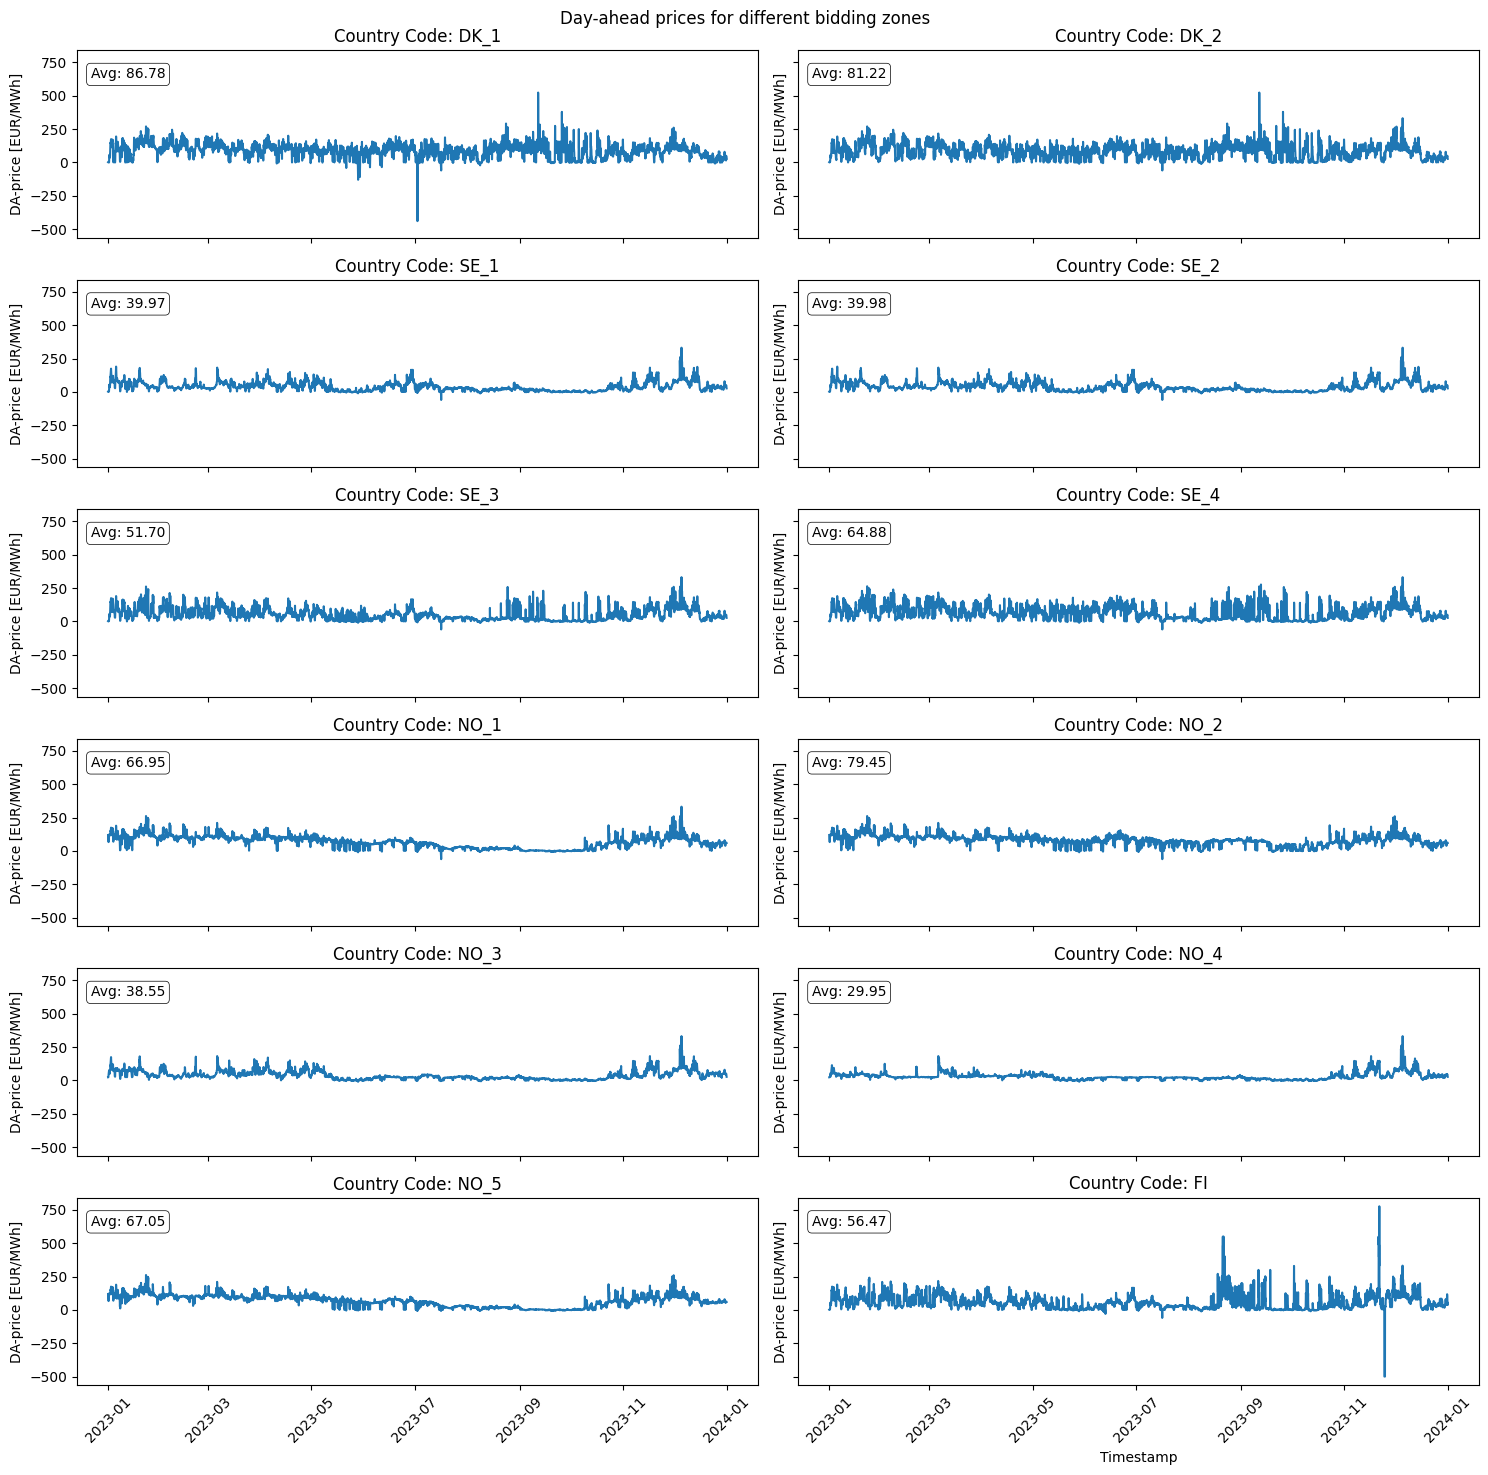

In [44]:
# Get unique country codes
unique_country_codes = data_df['country_code'].unique()

# Create subplots for each country code in a 3x4 grid
fig, axs = plt.subplots(6, 2, figsize=(15, 15), sharex=True, sharey=True)

# Flatten axs array for easier iteration
axs = axs.flatten()

# Plot DA-prices with the country_code as labels
for i, country_code in enumerate(unique_country_codes):
    data_df_country = data_df[data_df['country_code'] == country_code]
    axs[i].plot(data_df_country['Timestamp'], data_df_country['DA-price [EUR/MWh]'])
    axs[i].set_ylabel('DA-price [EUR/MWh]')
    axs[i].set_title(f'Country Code: {country_code}')
    axs[i].tick_params(axis='x', rotation=45)
    
    # annotate avg value in top left corner of each subplot
    avg_value = data_df_country['DA-price [EUR/MWh]'].mean()
    axs[i].annotate(f'Avg: {avg_value:.2f}', xy=(0.02, 0.85), xycoords='axes fraction', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))


# Set common x-label
plt.xlabel('Timestamp')
# make overall title
plt.suptitle('Day-ahead prices for different bidding zones')
#rotate x-labels for all subplots

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('plots/DA-prices.png')
plt.show()


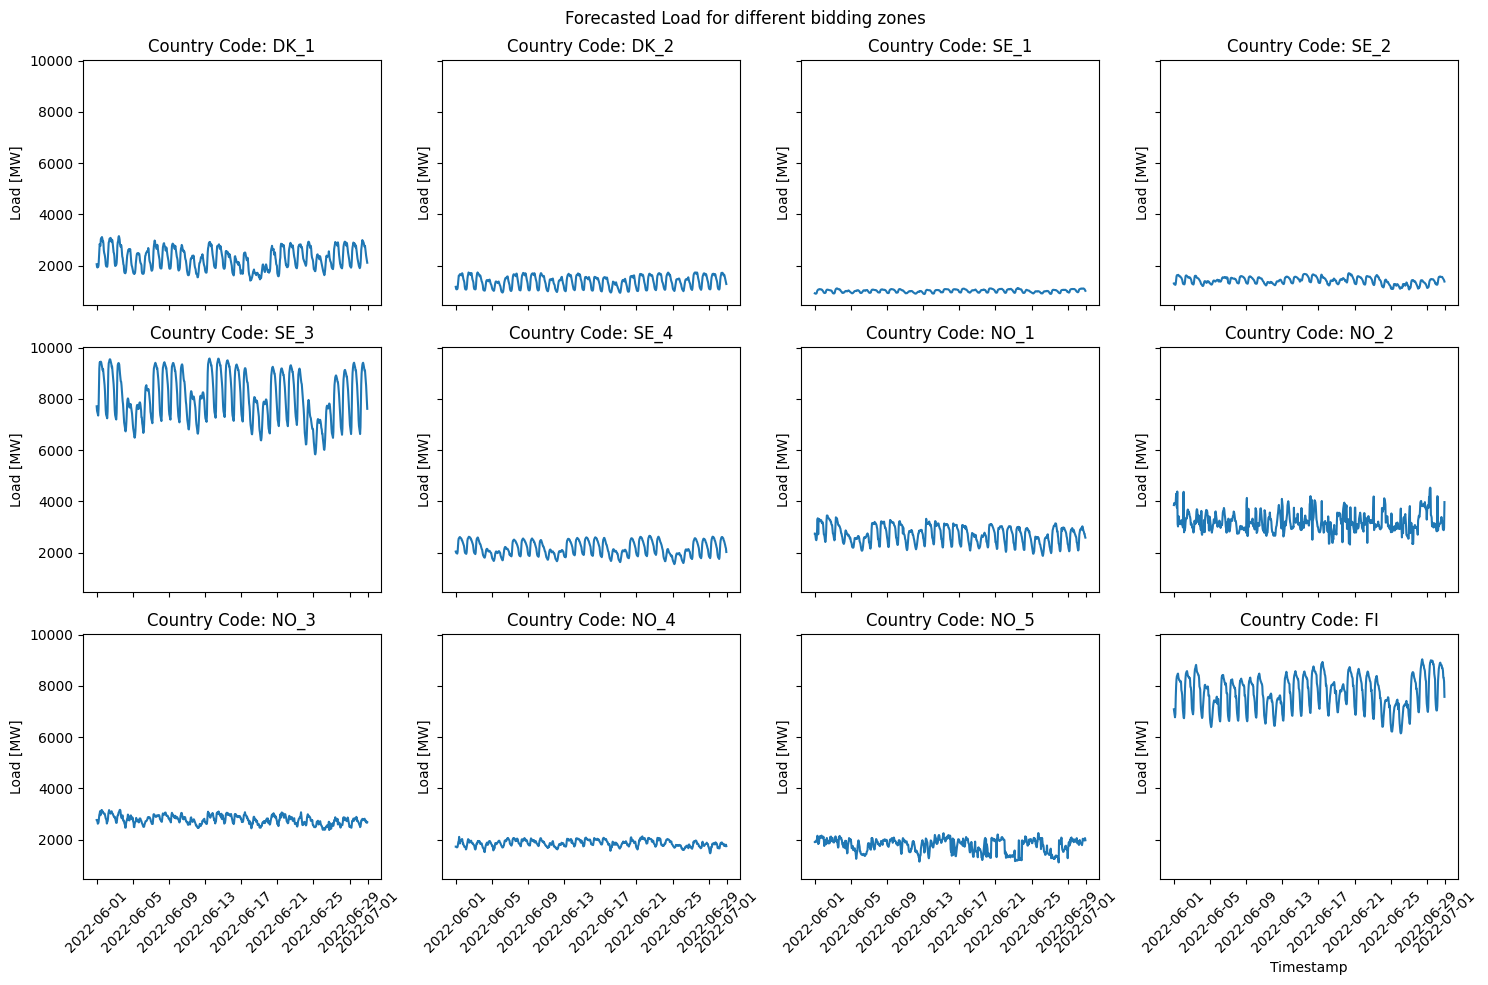

In [33]:
#%%
#make similar plots for the other dataframes
#load
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, country_code in enumerate(unique_country_codes):
    data_df_country = data_df[data_df['country_code'] == country_code]
    axs[i].plot(data_df_country['Timestamp'], data_df_country['Forecasted Load'])
    axs[i].set_ylabel('Load [MW]')
    axs[i].set_title(f'Country Code: {country_code}')
    axs[i].tick_params(axis='x', rotation=45)

plt.xlabel('Timestamp')
plt.suptitle('Forecasted Load for different bidding zones')

plt.tight_layout()
plt.savefig('plots/Forecasted_Load.png')
plt.show()

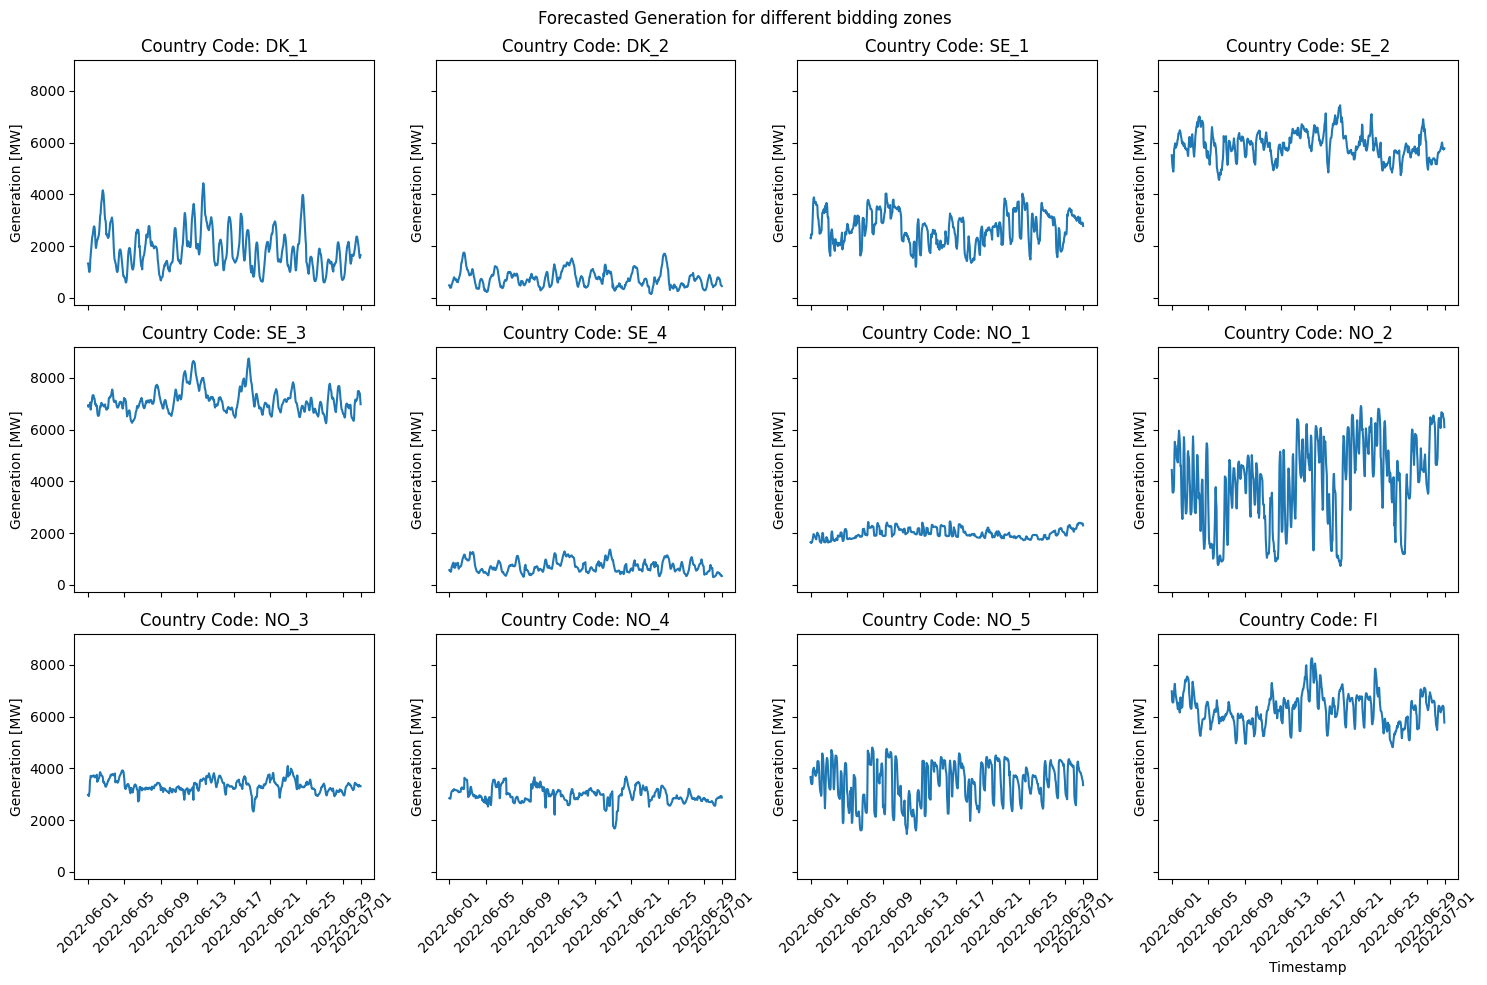

In [34]:
#%%
#generation forecast
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, country_code in enumerate(unique_country_codes):
    data_df_country = data_df[data_df['country_code'] == country_code]
    axs[i].plot(data_df_country['Timestamp'], data_df_country['Forecasted Generation'])
    axs[i].set_ylabel('Generation [MW]')
    axs[i].set_title(f'Country Code: {country_code}')
    axs[i].tick_params(axis='x', rotation=45)
    
plt.xlabel('Timestamp')
plt.suptitle('Forecasted Generation for different bidding zones')

plt.tight_layout()
plt.savefig('plots/Forecasted_Generation.png')
plt.show()

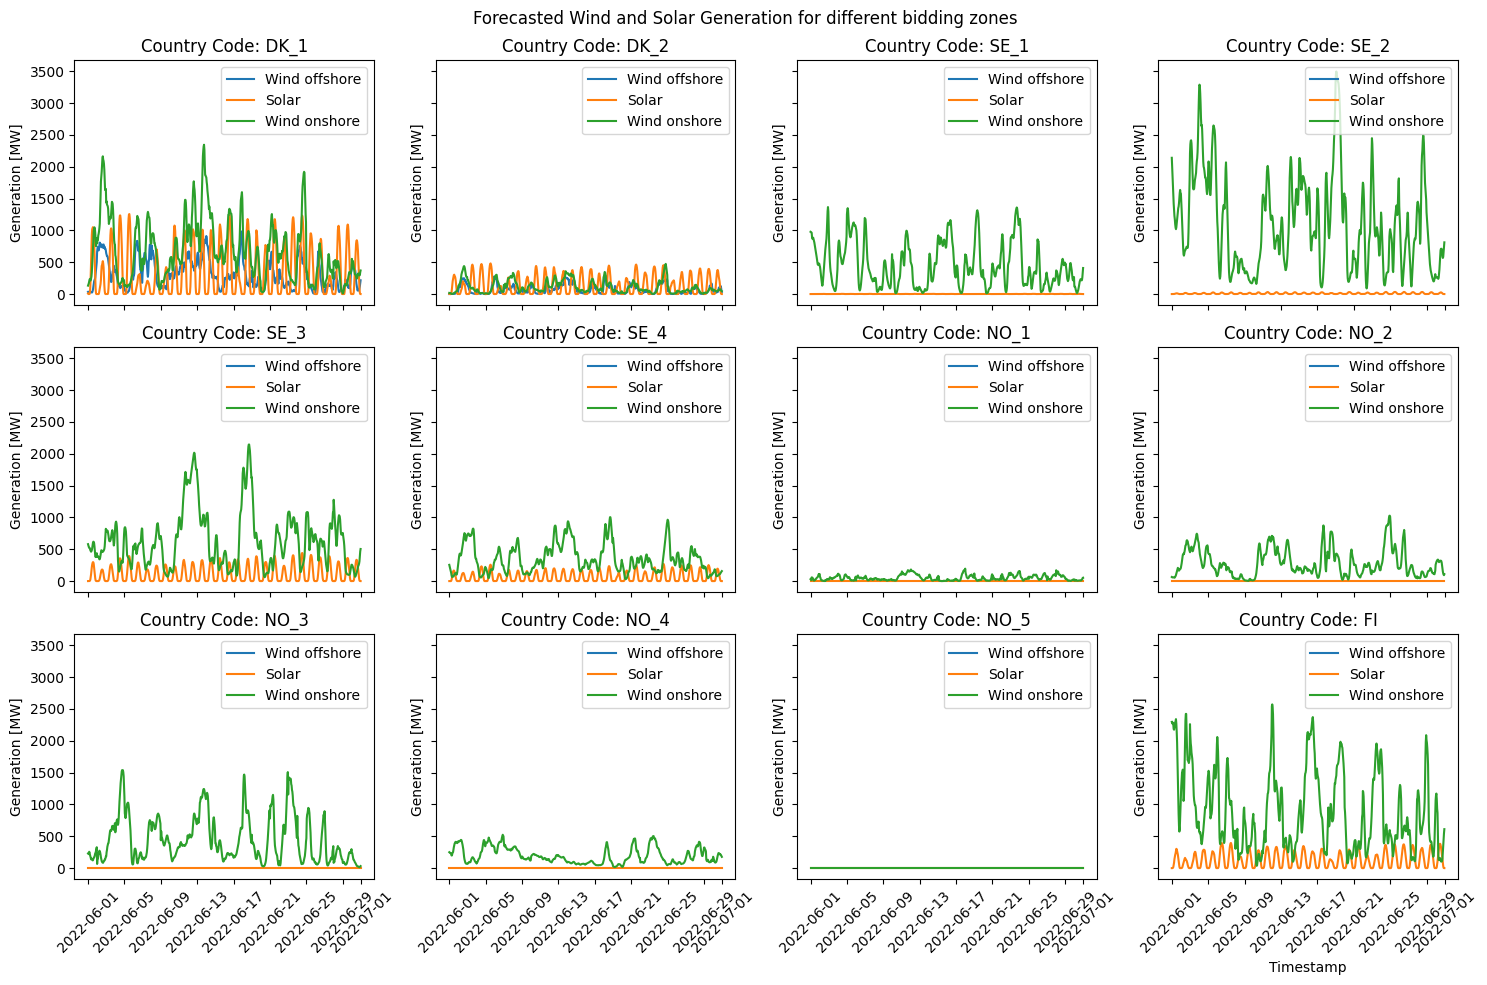

In [31]:
#%%
#wind and solar forecast
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, country_code in enumerate(unique_country_codes):
    data_df_country = data_df[data_df['country_code'] == country_code]
    axs[i].plot(data_df_country['Timestamp'], data_df_country['Wind Offshore'], label='Wind offshore')
    axs[i].plot(data_df_country['Timestamp'], data_df_country['Solar'], label='Solar')
    axs[i].plot(data_df_country['Timestamp'], data_df_country['Wind Onshore'], label='Wind onshore')
    axs[i].set_ylabel('Generation [MW]')
    axs[i].set_title(f'Country Code: {country_code}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].legend()
    
plt.xlabel('Timestamp')
plt.suptitle('Forecasted Wind and Solar Generation for different bidding zones')

plt.tight_layout()
plt.savefig('plots/Forecasted_Wind_Solar.png')
plt.show()

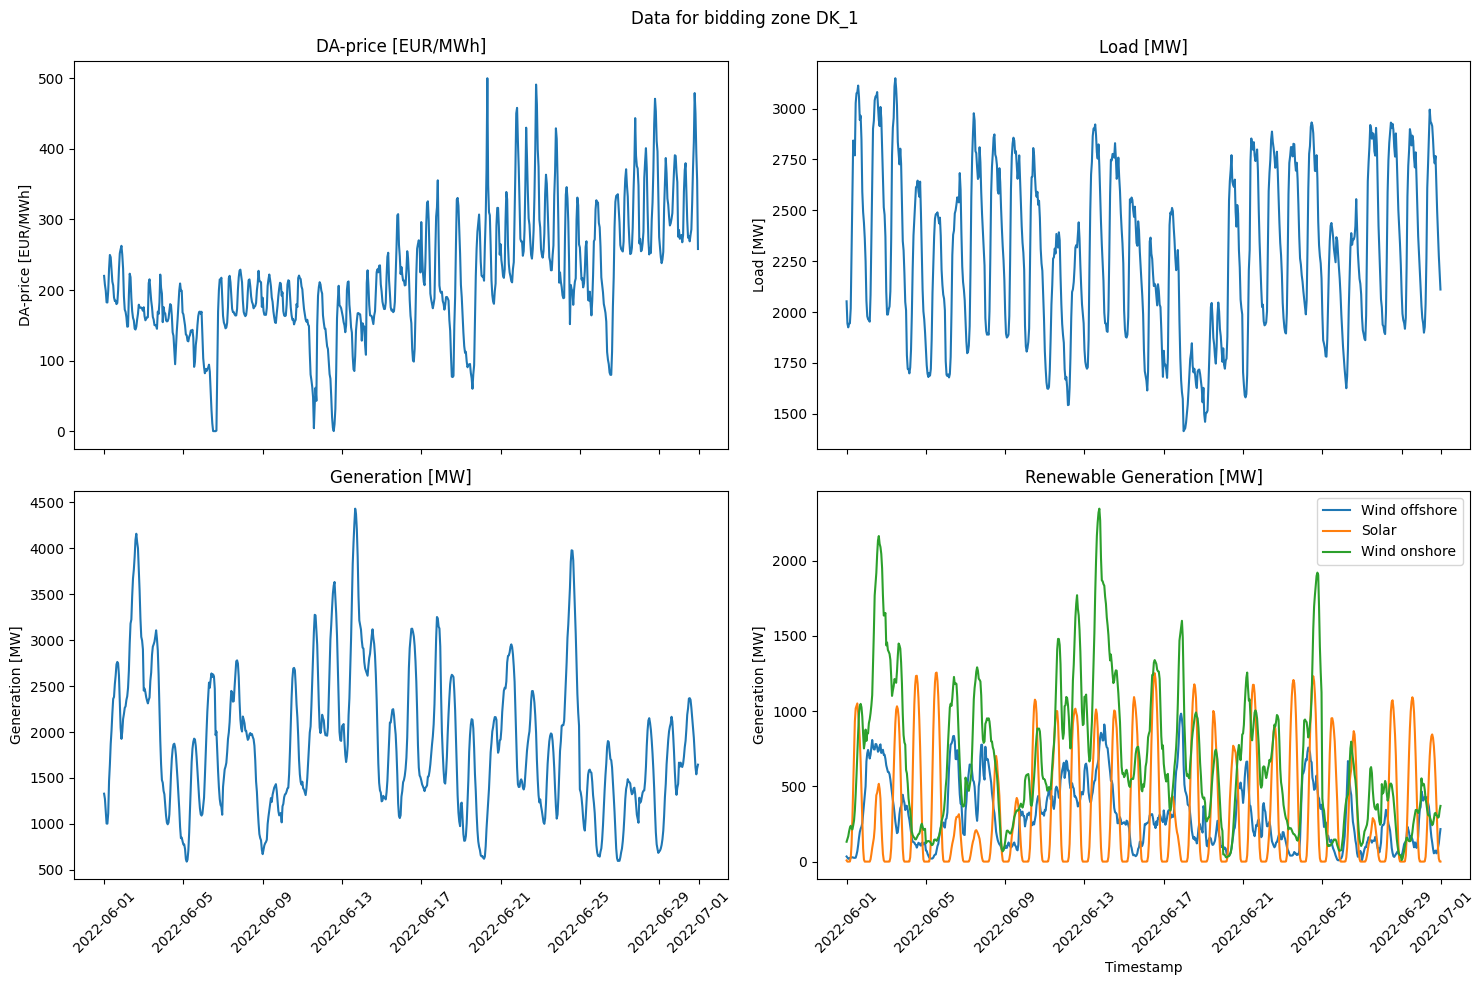

In [35]:
#%%
# for DK_1, plot day-ahead prices, load, forecasted generation, wind and solar forecast in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)
axs = axs.flatten()
country_code = 'DK_1'
data_df_country = data_df[data_df['country_code'] == country_code]
axs[0].plot(data_df_country['Timestamp'], data_df_country['DA-price [EUR/MWh]'])
axs[0].set_ylabel('DA-price [EUR/MWh]')
axs[0].set_title('DA-price [EUR/MWh]')
axs[0].tick_params(axis='x', rotation=45)

axs[1].plot(data_df_country['Timestamp'], data_df_country['Forecasted Load'])
axs[1].set_ylabel('Load [MW]')
axs[1].set_title('Load [MW]')
axs[1].tick_params(axis='x', rotation=45)

axs[2].plot(data_df_country['Timestamp'], data_df_country['Forecasted Generation'])
axs[2].set_ylabel('Generation [MW]')
axs[2].set_title('Generation [MW]')
axs[2].tick_params(axis='x', rotation=45)

axs[3].plot(data_df_country['Timestamp'], data_df_country['Wind Offshore'], label='Wind offshore')
axs[3].plot(data_df_country['Timestamp'], data_df_country['Solar'], label='Solar')
axs[3].plot(data_df_country['Timestamp'], data_df_country['Wind Onshore'], label='Wind onshore')
axs[3].set_ylabel('Generation [MW]')
axs[3].set_title('Renewable Generation [MW]')
axs[3].tick_params(axis='x', rotation=45)
axs[3].legend()

plt.xlabel('Timestamp')
plt.suptitle('Data for bidding zone DK_1')

plt.tight_layout()
plt.savefig('plots/DK_1_data.png')
plt.show()
